In [84]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP


In [85]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [87]:
data = pd.read_csv("bibledata.csv")

In [88]:
#for each sentence, the mean of 6-nearest embeddings are stored
means = torch.load("bible_similar_mean.pt", map_location = device)
embeddings = torch.load("bible_embeddings.pt", map_location = device)

styles = embeddings - means
target = F.normalize(styles)

In [89]:
similarity_matrix = embeddings.matmul(embeddings.T)

In [90]:
#For each embedding, the top 6 most similar vectors are stored
top_n = similarity_matrix.sort()[1][:,-7:-1]

In [91]:
random.seed(42)
dataset = TensorDataset(embeddings, target, torch.arange(len(data)).to(device))
train_dataloader = DataLoader(dataset, batch_size=73, shuffle=True, drop_last = True)

In [92]:
l1 = 256
l2 = 128
z_dim = 64

In [93]:
class L2Norm(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(L2Norm, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        self.dim = len(x.shape) - 1
        return F.normalize(x, p=2, dim=self.dim, eps=self.eps)

In [94]:
def Encoder(x_dim, z_dim):
  model = nn.Sequential(
    nn.Linear(x_dim, l1),
    nn.ReLU(),
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, z_dim))
  return model

In [95]:
def Decoder(x_dim, z_dim):
  model = nn.Sequential(
    nn.Linear(z_dim, l2),
    nn.ReLU(),
    nn.Linear(l2, l1),
    nn.ReLU(),
    nn.Linear(l1, x_dim),
    L2Norm())
  return model

In [96]:
class Model(nn.Module):
  def __init__(self, x_dim, z_dim, eps = 0.005):
      super(Model, self).__init__()
      self.Encoder = Encoder(x_dim, z_dim)
      self.Decoder = Decoder(x_dim, z_dim)
      self.eps = eps

  def perturb(self, x, eps=None):
      if eps is None:
        eps = self.eps
      return x + eps*torch.randn(x.shape).to(device)

  def forward(self, x):
      x = self.perturb(x)
      z = self.Encoder(x)
      out = self.Decoder(z)
        
      return out

In [97]:
epochs = 50
batch_size = 73

In [98]:
model = Model(384, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [99]:
for epoch in tqdm(range(epochs)):
    overall_loss = 0
    for batch_idx, (x, label, index) in enumerate(train_dataloader):
        x = x.view(batch_size, 384)
        nearest = embeddings[top_n[index]]

        optimizer.zero_grad()
        predict = model(x)
        nears = model.Encoder(nearest)

        #Reconstruction Loss 
        loss = 1*torch.sum(torch.square(1 - F.cosine_similarity(predict, label)))
        #Positive-example loss 
        loss += 1*torch.sum(torch.square(1 - F.cosine_similarity(model.Encoder(x), model.Encoder(model.perturb(x, model.eps*10)))))
        #Negative-example loss 
        loss += 1/6*torch.sum(torch.square(F.cosine_similarity(model.Encoder(x).unsqueeze(1), nears, dim=2)))
      
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*64))

  2%|▏         | 1/50 [00:01<00:53,  1.09s/it]

	Epoch 1 complete! 	Average Loss:  1.5365941712301072


  4%|▍         | 2/50 [00:02<00:51,  1.08s/it]

	Epoch 2 complete! 	Average Loss:  1.167869070621386


  6%|▌         | 3/50 [00:03<00:50,  1.08s/it]

	Epoch 3 complete! 	Average Loss:  1.0579497373267397


  8%|▊         | 4/50 [00:04<00:50,  1.09s/it]

	Epoch 4 complete! 	Average Loss:  0.9853971041228673


 10%|█         | 5/50 [00:05<00:48,  1.07s/it]

	Epoch 5 complete! 	Average Loss:  0.9324595177010314


 12%|█▏        | 6/50 [00:06<00:52,  1.19s/it]

	Epoch 6 complete! 	Average Loss:  0.8920843597144297


 14%|█▍        | 7/50 [00:08<00:54,  1.28s/it]

	Epoch 7 complete! 	Average Loss:  0.8588417776643413


 16%|█▌        | 8/50 [00:09<00:53,  1.27s/it]

	Epoch 8 complete! 	Average Loss:  0.8307967667710291


 18%|█▊        | 9/50 [00:10<00:49,  1.21s/it]

	Epoch 9 complete! 	Average Loss:  0.8070866698271608


 20%|██        | 10/50 [00:11<00:46,  1.16s/it]

	Epoch 10 complete! 	Average Loss:  0.7865010814307487


 22%|██▏       | 11/50 [00:12<00:44,  1.13s/it]

	Epoch 11 complete! 	Average Loss:  0.7682933582835001


 24%|██▍       | 12/50 [00:13<00:41,  1.10s/it]

	Epoch 12 complete! 	Average Loss:  0.7508226057438001


 26%|██▌       | 13/50 [00:14<00:40,  1.09s/it]

	Epoch 13 complete! 	Average Loss:  0.7344973458819193


 28%|██▊       | 14/50 [00:15<00:38,  1.07s/it]

	Epoch 14 complete! 	Average Loss:  0.7279036290025058


 30%|███       | 15/50 [00:16<00:37,  1.07s/it]

	Epoch 15 complete! 	Average Loss:  0.7136757814720885


 32%|███▏      | 16/50 [00:17<00:36,  1.06s/it]

	Epoch 16 complete! 	Average Loss:  0.7043343227203578


 34%|███▍      | 17/50 [00:19<00:35,  1.07s/it]

	Epoch 17 complete! 	Average Loss:  0.6920604954843652


 36%|███▌      | 18/50 [00:20<00:38,  1.20s/it]

	Epoch 18 complete! 	Average Loss:  0.6850342346380834


 38%|███▊      | 19/50 [00:22<00:39,  1.28s/it]

	Epoch 19 complete! 	Average Loss:  0.6751509815046232


 40%|████      | 20/50 [00:23<00:37,  1.25s/it]

	Epoch 20 complete! 	Average Loss:  0.665614759268826


 42%|████▏     | 21/50 [00:24<00:34,  1.20s/it]

	Epoch 21 complete! 	Average Loss:  0.6589868174840326


 44%|████▍     | 22/50 [00:25<00:32,  1.16s/it]

	Epoch 22 complete! 	Average Loss:  0.6506257538926111


 46%|████▌     | 23/50 [00:26<00:30,  1.14s/it]

	Epoch 23 complete! 	Average Loss:  0.6438968357158034


 48%|████▊     | 24/50 [00:27<00:28,  1.11s/it]

	Epoch 24 complete! 	Average Loss:  0.6413289194237696


 50%|█████     | 25/50 [00:28<00:27,  1.09s/it]

	Epoch 25 complete! 	Average Loss:  0.6331299588288346


 52%|█████▏    | 26/50 [00:29<00:25,  1.07s/it]

	Epoch 26 complete! 	Average Loss:  0.627792186933021


 54%|█████▍    | 27/50 [00:30<00:24,  1.07s/it]

	Epoch 27 complete! 	Average Loss:  0.6225618328133674


 56%|█████▌    | 28/50 [00:31<00:23,  1.06s/it]

	Epoch 28 complete! 	Average Loss:  0.6173016763713262


 58%|█████▊    | 29/50 [00:32<00:23,  1.10s/it]

	Epoch 29 complete! 	Average Loss:  0.6142582244252506


 60%|██████    | 30/50 [00:34<00:24,  1.21s/it]

	Epoch 30 complete! 	Average Loss:  0.6084583899746202


 62%|██████▏   | 31/50 [00:35<00:24,  1.29s/it]

	Epoch 31 complete! 	Average Loss:  0.6041914694113274


 64%|██████▍   | 32/50 [00:36<00:21,  1.21s/it]

	Epoch 32 complete! 	Average Loss:  0.5986020871221203


 66%|██████▌   | 33/50 [00:37<00:19,  1.16s/it]

	Epoch 33 complete! 	Average Loss:  0.594411016735312


 68%|██████▊   | 34/50 [00:38<00:18,  1.13s/it]

	Epoch 34 complete! 	Average Loss:  0.5918160409551777


 70%|███████   | 35/50 [00:39<00:16,  1.10s/it]

	Epoch 35 complete! 	Average Loss:  0.5892655196255201


 72%|███████▏  | 36/50 [00:40<00:15,  1.08s/it]

	Epoch 36 complete! 	Average Loss:  0.5840248465538025


 74%|███████▍  | 37/50 [00:42<00:14,  1.08s/it]

	Epoch 37 complete! 	Average Loss:  0.5819383957614638


 76%|███████▌  | 38/50 [00:43<00:12,  1.07s/it]

	Epoch 38 complete! 	Average Loss:  0.5790678560733795


 78%|███████▊  | 39/50 [00:44<00:11,  1.07s/it]

	Epoch 39 complete! 	Average Loss:  0.5762735172493817


 80%|████████  | 40/50 [00:45<00:10,  1.07s/it]

	Epoch 40 complete! 	Average Loss:  0.572800197829939


 82%|████████▏ | 41/50 [00:46<00:10,  1.13s/it]

	Epoch 41 complete! 	Average Loss:  0.5682544500043948


 84%|████████▍ | 42/50 [00:47<00:09,  1.23s/it]

	Epoch 42 complete! 	Average Loss:  0.5666971516935793


 86%|████████▌ | 43/50 [00:49<00:09,  1.29s/it]

	Epoch 43 complete! 	Average Loss:  0.5628422523198062


 88%|████████▊ | 44/50 [00:50<00:07,  1.22s/it]

	Epoch 44 complete! 	Average Loss:  0.5614804413220654


 90%|█████████ | 45/50 [00:51<00:06,  1.25s/it]

	Epoch 45 complete! 	Average Loss:  0.557583700712413


 92%|█████████▏| 46/50 [00:53<00:05,  1.39s/it]

	Epoch 46 complete! 	Average Loss:  0.5565846548096774


 94%|█████████▍| 47/50 [00:54<00:04,  1.41s/it]

	Epoch 47 complete! 	Average Loss:  0.5546603445729165


 96%|█████████▌| 48/50 [00:56<00:02,  1.30s/it]

	Epoch 48 complete! 	Average Loss:  0.551765208783215


 98%|█████████▊| 49/50 [00:57<00:01,  1.23s/it]

	Epoch 49 complete! 	Average Loss:  0.5498076761013841


100%|██████████| 50/50 [00:58<00:00,  1.16s/it]

	Epoch 50 complete! 	Average Loss:  0.5467057379141246


In [100]:
#Compute KMeans clustering on encoded style vectors
zs = model.Encoder(embeddings).detach().cpu()
km = KMeans(n_clusters = 7)
km.fit(zs)
data["labels"] = km.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [101]:
v_measure_score(data.id, data.labels)

0.4015925412479833

In [102]:
km.fit(styles.cpu().detach())
data["ll"] = km.labels_
v_measure_score(data.id, data.ll)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.3121354949445955

In [109]:
torch.save(model.state_dict(), "model-checkpoint.pt")

In [104]:
x = data.pivot_table(index = 'id', columns = 'labels', values = 'text', aggfunc = "count").fillna(0).astype(int)
y = data.pivot_table(index = 'id', columns = 'll', values = 'text', aggfunc = "count").fillna(0).astype(int)

In [105]:
#Compute microaverage and macroaverage
print((x.max() / x.sum()).mean())
print(x.max().sum()/x.sum().sum())

0.7509370820321859
0.47963843071475165


In [106]:
print((y.max() / y.sum()).mean())
print(y.max().sum()/y.sum().sum())

0.6232107737369663
0.4258689777280775


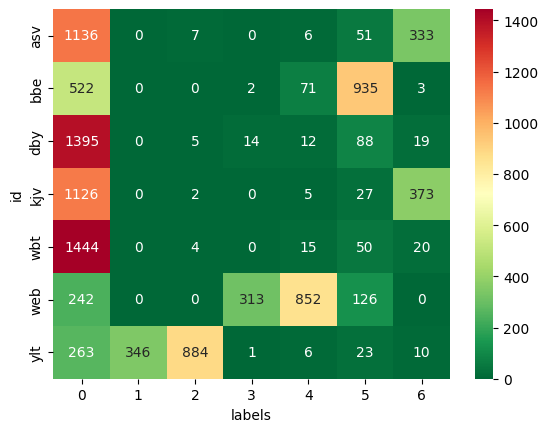

In [107]:
sns.heatmap(x, annot = True, fmt = 'd', cmap='RdYlGn_r')
plt.savefig('heatmap.png')

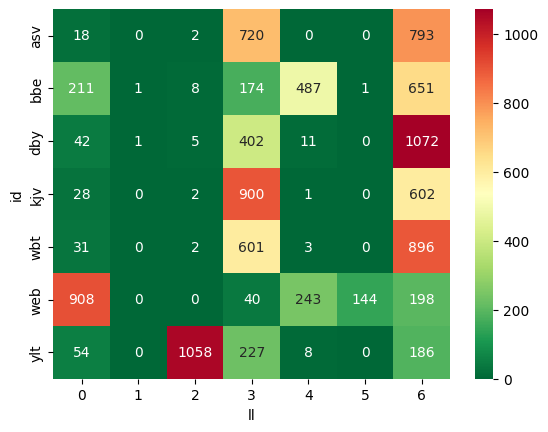

In [108]:
sns.heatmap(y, annot = True, fmt = 'd', cmap='RdYlGn_r')
plt.savefig('l_heatmap.png')